In [21]:
#!/usr/bin/env python3
"""
HRP Portfolio Optimizer
Author: John E. Putman II
Date: 12/13/2024
"""

# Standard library imports
import sys
import warnings
from pathlib import Path

# Configure path
notebook_dir = Path.cwd()
project_root = notebook_dir.parent
sys.path.append(str(project_root))

# Third-party imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Suppress warnings
warnings.filterwarnings('ignore')

# Local application imports
from src.proc.data_handler import DataHandler
from src.hrp.optimizer import HRPPortfolio
from src.viz.plots import plot_portfolio_analysis


In [22]:
# Environment Information
print(f"Python version: {sys.version}")
print("\nKey package versions:")
for package in ['numpy', 'pandas', 'matplotlib', 'yfinance']:
    print(f"{package}: {__import__(package).__version__}")

Python version: 3.11.2 (tags/v3.11.2:878ead1, Feb  7 2023, 16:38:35) [MSC v.1934 64 bit (AMD64)]

Key package versions:
numpy: 1.23.5
pandas: 1.5.3
matplotlib: 3.7.1
yfinance: 0.2.36


In [27]:
class PortfolioManager:
    def __init__(self, risk_free_rate: float = 0.02):
        self.data_handler = DataHandler()
        self.portfolio = HRPPortfolio(risk_free_rate=risk_free_rate)
        
    def run_portfolio_optimization(
        self,
        data_path: str,
        min_market_cap: int,
        start_date: str,
        end_date: str,
        num_clusters: int = 3,
        risk_measure: str = "variance",
        n_stocks: int = 100
    ):
        df = self.data_handler.load_market_data(data_path, min_market_cap)
        df = self.data_handler.calculate_quality_metrics(df)
        df = self.data_handler.calculate_financial_strength(df)
        df = self.data_handler.calculate_value_metrics(df)
        df = self.data_handler.calculate_composite_score(df)
        
        top_n = df.head(n_stocks)
        hrp_df = pd.DataFrame({
            'ticker': top_n['Full Ticker'].str.split(':').str[1],
            'market_cap': top_n['market_cap']
        })
        
        portfolio_metrics = self.portfolio.optimize_portfolio(
            tickers=hrp_df['ticker'].tolist(),
            market_caps=hrp_df['market_cap'].values,
            start_date=start_date,
            end_date=end_date,
            num_clusters=num_clusters,
            risk_measure=risk_measure,
            max_weight = .15
        )
        
        results = pd.DataFrame({
            'Weight': portfolio_metrics.weights,
            'Cluster': portfolio_metrics.clusters
        })
        results['Market_Cap'] = hrp_df.set_index('ticker')['market_cap']
        
        fig = plot_portfolio_analysis(
            portfolio_metrics.returns,
            portfolio_metrics.weights,
            portfolio_metrics.linkage_matrix
        )
        plt.show()
        
        return results

2024-12-17 10:52:42,995 - DataHandler - WARNING - Unusual interest coverage ratios (<-100) found for:
Tickers: ['NASDAQGS:MRNA']
Values: [-112.2083]
Tickers: ['NASDAQGS:MRNA']
Values: [-112.2083]
INFO:src.hrp.optimizer:Downloading historical data...
[*********************100%%**********************]  100 of 100 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
INFO:src.hrp.optimizer:Calculating distance matrix...
INFO:src.hrp.optimizer:Performing hierarchical clustering...


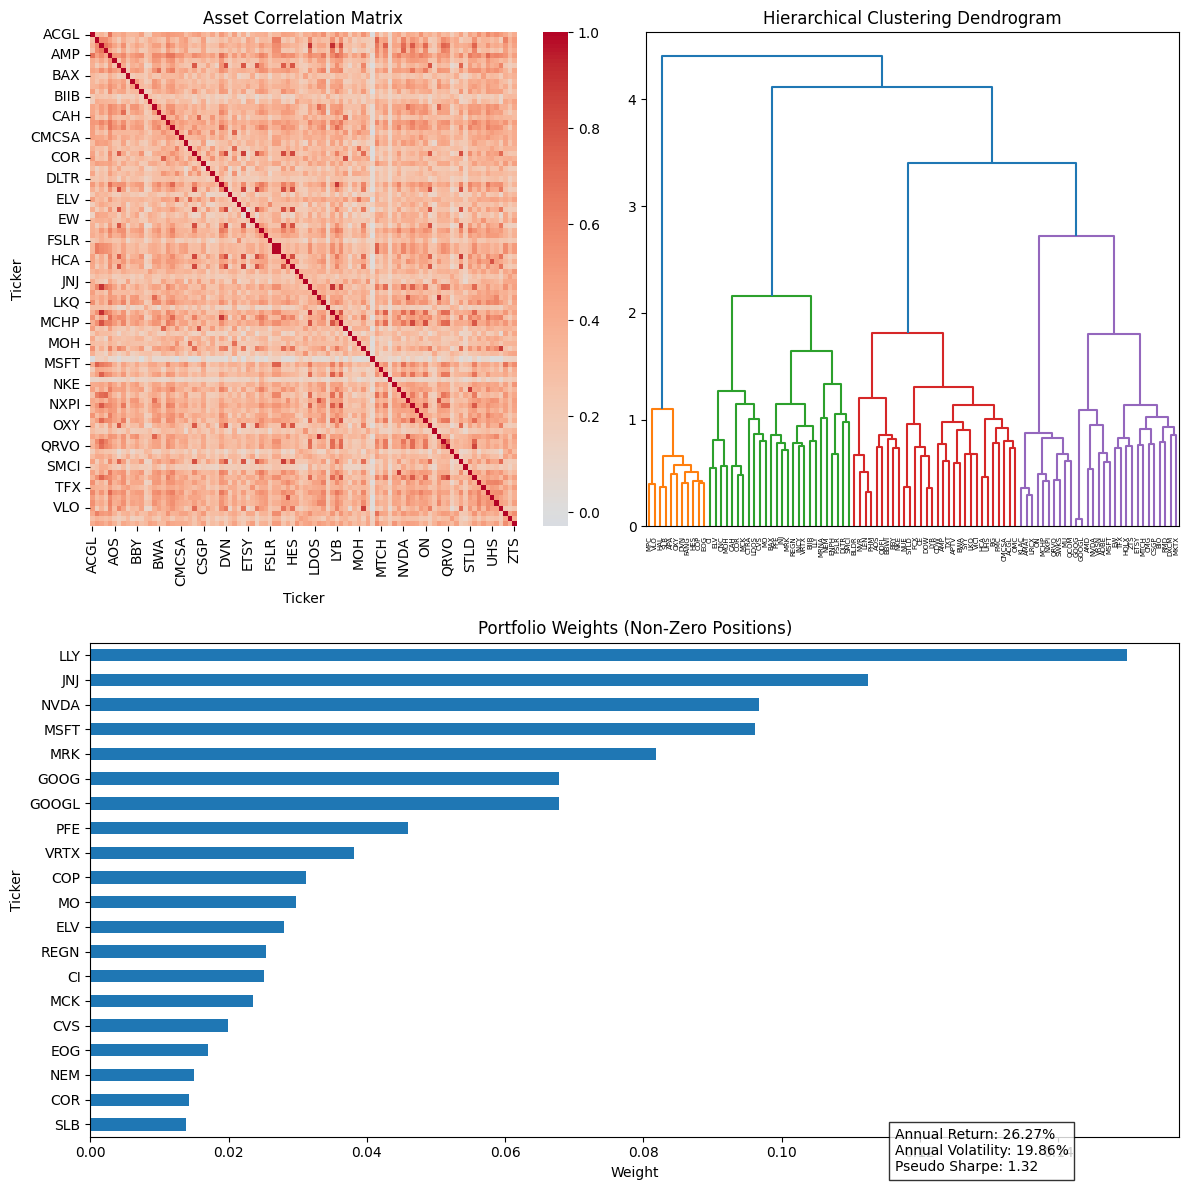


Portfolio Summary:
          Weight  Cluster    Market_Cap
Ticker                                 
LLY     0.150000        2  7.044530e+05
JNJ     0.112441        2  3.520908e+05
NVDA    0.096689        3  3.363457e+06
MSFT    0.096084        3  3.342425e+06
MRK     0.081794        2  2.561256e+05
GOOGL   0.067814        3  2.359024e+06
GOOG    0.067814        3  2.359024e+06
PFE     0.045914        2  1.437715e+05
VRTX    0.038171        2  1.195245e+05
COP     0.031214        1  1.305334e+05


In [28]:
if __name__ == "__main__":
    manager = PortfolioManager(risk_free_rate=0.02)
    results = manager.run_portfolio_optimization(
        data_path='../data/sp500_data.csv',
        min_market_cap=2000,
        start_date="2019-05-01",
        end_date="2024-12-10"
    )
    
    if results is not None:
        print("\nPortfolio Summary:")
        print(results.sort_values('Weight', ascending=False).head(10))